In [234]:
# %matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from joblib import load

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Feng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [235]:
dataset_directory = "C:/Users/Feng/Coding projects/toxic-comments-datasets/"
df = pd.read_csv(dataset_directory + "train.csv.zip")

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [237]:
df[df['toxic']==1].sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
13053,22919edbd0d49dfb,"Oh, shit! I've been blocked! Whatever will I d...",1,0,1,0,1,0
122192,8dad3e32bc79fc60,"""\n\nYou invalidate my contribution and then a...",1,0,0,0,0,0
27314,4847118553b120bd,! YOU INDEED HAVE NO QUALIFICATION TO JUDGE OT...,1,0,0,0,0,0
146662,2fa9472be53590b1,"Hey Simon Remember Me \n\nYeah, were back \nan...",1,0,0,0,0,0
158571,f00847efdea5faa3,That Lestrade is obviously mentally disturbed...,1,0,0,0,0,0


   number_of_labels   count  fraction  percentage
0                 0  143346     0.898       89.83
1                 1    6360     0.040        3.99
2                 3    4209     0.026        2.64
3                 2    3480     0.022        2.18
4                 4    1760     0.011        1.10
5                 5     385     0.002        0.24
6                 6      31     0.000        0.02


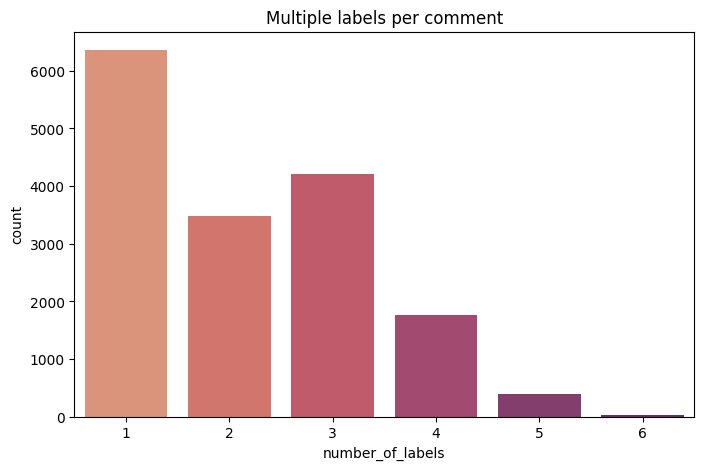

In [238]:

# finding 
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
count_per_comment =  pd.DataFrame({'number_of_labels': x.index, 'count':x.values, 
                                   'fraction': np.round(x.values/len(df),3), 
                                   'percentage':np.round(100*x.values/len(df),2) })
count_per_comment.to_csv('multilabel_counts.csv')

print(count_per_comment)

fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(data = count_per_comment[1:], x = 'number_of_labels', y = 'count', palette='flare')
plt.title("Multiple labels per comment")
# plt.ylabel('# of Occurrences', fontsize=12)
# plt.xlabel('# of categories', fontsize=12)
plt.show()


In [239]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['no_labels'] = 1 - df[LABELS].max(axis=1)

df_labels = df.drop(['id', 'comment_text'], axis=1)
counts = []
# fraction = []
labels = list(df_labels.columns.values)
length = len(df)

for label in labels:
    total = df_labels[label].sum()
    fraction = total/length
    percentages = np.round(fraction * 100, 1)
    counts.append((label, total, fraction, percentages))
    
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments', 'fraction', 'percentages'])
print(df_stats)
# df_stats.to_csv(dataset_directory + 'df_stats.csv')
df_stats_sorted = df_stats.sort_values('number_of_comments', ascending=False)

        category  number_of_comments  fraction  percentages
0          toxic               15294  0.095844          9.6
1   severe_toxic                1595  0.009996          1.0
2        obscene                8449  0.052948          5.3
3         threat                 478  0.002996          0.3
4         insult                7877  0.049364          4.9
5  identity_hate                1405  0.008805          0.9
6      no_labels              143346  0.898321         89.8


In [240]:
print('Are there missing values in the data?')
print(df.isna().sum())

Are there missing values in the data?
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
no_labels        0
dtype: int64


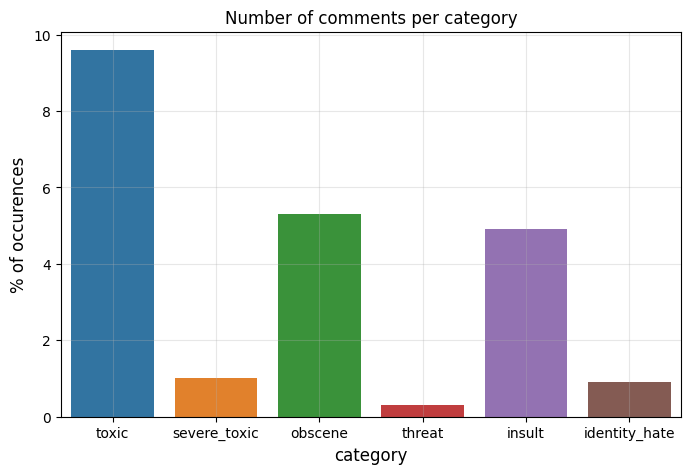

In [241]:
df_stats = df_stats.drop([6], axis=0)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data = df_stats, x='category', y='percentages', ax=ax)
plt.title("Number of comments per category")
plt.ylabel('% of occurences', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.grid(True, alpha=0.3)

## Text Length

In [242]:
def word_count(text):
    words = text.split()
    return len(words)

num_words = []
len_text = []
for text in df['comment_text']:
    num_words.append(word_count(text))
    len_text.append(len(text))

df['num_words'] = num_words
df['text_length'] = len_text

df_labels['num_words'] = num_words
df_labels['text_length'] = len_text

# print(df.head())

In [243]:
print(df['num_words'].mean())
print(df['text_length'].mean())

print(df['num_words'].max())
print(df['text_length'].max())

67.27352714465661
394.0732213246768
1411
5000


Text(0.5, 1.0, 'Distribution of text lengths')

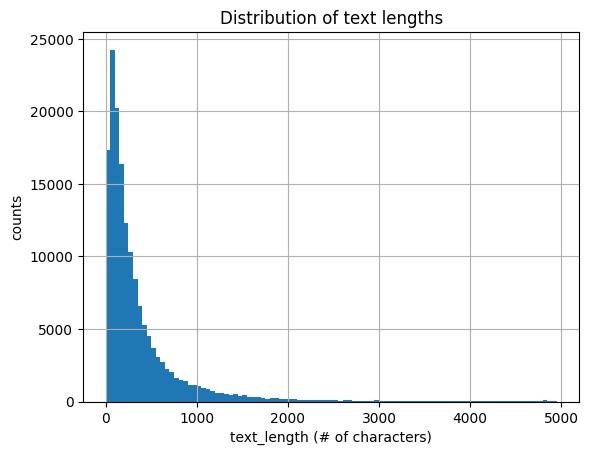

In [244]:
df_labels['text_length'].hist(bins = np.arange(0,5000,50))
plt.xlabel('text_length (# of characters)')
plt.ylabel('counts')
plt.title('Distribution of text lengths')

## Data Mining with Regex

In [306]:
bad_comments = df[df.severe_toxic==1]['comment_text'].sample(10)
print(bad_comments.values)

def find_captials(text):
    matches = re.findall(r"[A-Z!]", text)
    return len(matches)/len(text)

print(bad_comments.apply(capitals_ratio))

def find_repeats(text):
    repeats = re.findall(r"(.+)\s\1", text)
    repeats = " ".join(repeats)
    return 2*len(repeats)/len(text)  # multiply by 2

print(bad_comments.apply(repeat_ratio))


["I don't give a shit this ain't my fuckin account wit yo dumbass what kind of fuckin nerd spends time on here just to make fix articles are you some fuckin teacher or somethin damn on my fridays i'm out wit friends and shit you just like my fuckin brotther after i get him  banned from here he comin wit me and yo nerdy virgin ass can sit on the damn computer"
 'Fuck off. You have unwarranted self importance.'
 'you people are cock suckers \n\nyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckersyou people are cock suckers'
 'You have a fucking huge ego for a fu

In [308]:
def find_captials(text):
    matches = re.findall(r"[A-Z!]", text)
    return len(matches)/len(text)

df['capitals_ratio'] = df['comment_text'].apply(find_captials)
display(df.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,no_labels,num_words,text_length,capitals_ratio
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,43,264,0.064394
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,17,112,0.080357
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,42,233,0.017167
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,113,622,0.017685
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,13,67,0.029851


CPU times: total: 1.03 s
Wall time: 1.03 s


In [ ]:
%%time  # this takes too long to run
df['repeat_ratio'] = df['comment_text'].apply(find_repeats)
display(df.head())


In [ ]:
f = open('bad_words_list.txt', 'r')
badwords = f.read().splitlines()
badword_pattern = ''

for i, bw in enumerate(badwords):
    if i < len(badwords)-1:
        badword_pattern += bw.strip()+'|'
    else:
        badword_pattern += bw

# print(badword_pattern)
regex_badwords = r"\b({})\b".format(badword_pattern)  # match each bad word whole

def bad_words_count(text, regex_badwords):
    matches = re.findall(regex_badwords, text.lower())
    return len(matches)

def bad_words_find(text, regex_badwords):
    matches = re.findall(regex_badwords, text.lower())
    return matches

df['bad_words_count'] = df['comment_text'].apply(bad_words_count, regex_badwords = regex_badwords)

In [309]:
regex_badwords = r"\b({})\b".format(badword_pattern)  # match each bad word whole

def bad_words_count(text, regex_badwords):
    matches = re.findall(regex_badwords, text.lower())
    return len(matches)

df['bad_words_count'] = df['comment_text'].apply(bad_words_count, regex_badwords = regex_badwords)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,no_labels,num_words,text_length,capitals_ratio,bad_words_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,43,264,0.064394,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,17,112,0.080357,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,42,233,0.017167,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,113,622,0.017685,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,13,67,0.029851,0


,capitals_ratio_mean,badwords_count_mean,labels
0,0.12,3.98,toxic
1,0.23,19.05,severe_toxic
2,0.13,6.14,obscene
3,0.16,3.84,threat
4,0.13,5.30,insult
5,0.15,6.95,identity_hate
6,0.05,0.05,no_labels


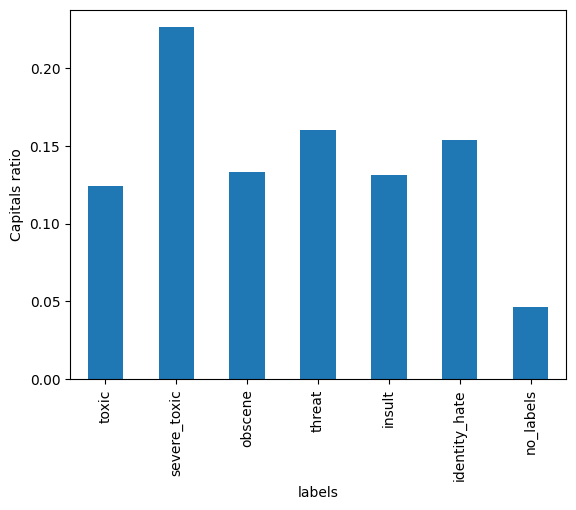

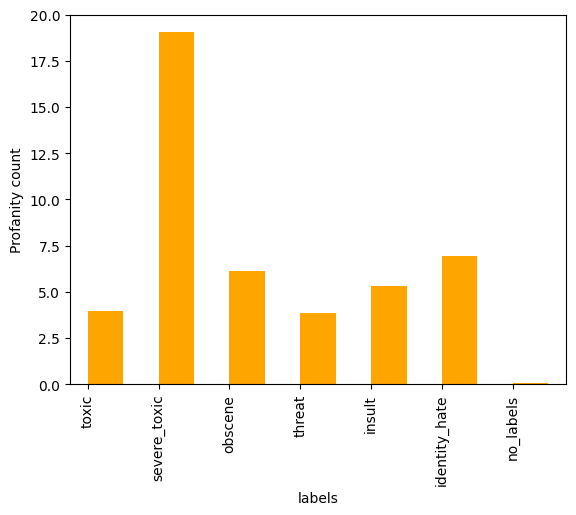

In [385]:
from icecream import ic
# display(df.describe())
newLABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'no_labels']

data_mine = pd.DataFrame()
cap_ratio, bw_count, text_len = [], [], []
for label in newLABELS:
    # print('--- {} ---'.format(label))
    cap_ratio.append(df[df[label]==1]['capitals_ratio'].mean())
    bw_count.append(df[df[label]==1]['bad_words_count'].mean())
    text_len.append(df[df[label]==1]['text_length'].mean())
    
data_mine['capitals_ratio_mean'] = cap_ratio
data_mine['badwords_count_mean'] = bw_count
data_mine['labels'] = newLABELS
# data_mine = data_mine.set_index('labels')
display(np.round(data_mine,2))

# sns.barplot(data=data_mine, x='labels', y='capitals_ratio')
# data_mine.plot(kind='bar', x='labels', y)

fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.5
data_mine.plot.bar(x='labels', y='capitals_ratio_mean', ax=ax, width=width, legend=False, label='Capitals ratio')
ax.set_ylabel('Capitals ratio')
# ax.legend(loc = 'upper left')

plt.show()

fig = plt.figure() # Create matplotlib figure
ax2 = fig.add_subplot(111) # Create matplotlib axes
# ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
data_mine.plot.bar(x='labels', y='badwords_count_mean', ax=ax2, width=width, position=0, legend=False, label='Profanity count', color='orange') 
ax2.set_ylabel('Profanity count')
# ax2.legend(loc = 'upper right')

plt.show()

<AxesSubplot: >

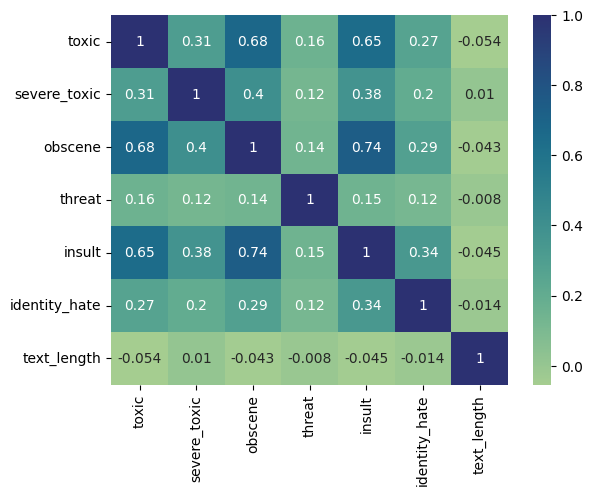

In [245]:
# corr_df = df[['no_labels', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'text_length', 'capitals_ratio', 'bad_words_count']].corr()

corr_df = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'text_length']].corr()

sns.heatmap(corr_df, annot=True, cmap='crest')

## Label filters
It appears that the majority any toxic comments are labelled toxic first, then a more specific label 'severe_toxic' - 'identity_hate'. What percentage of smaller labels are also labelled 'toxic'?

In [ ]:
# Creating boolean filters for each label
# use '~' symbol for the inverse of each filter
toxic_fltr = df['toxic']==1
severe_toxic_fltr = df['severe_toxic']==1
obscene_fltr = df['obscene']==1
threat_fltr = df['threat']==1
insult_fltr = df['insult']==1
identity_hate_fltr = df['identity_hate']==1


print('Percentage of comments that are not labelled:')
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['none'] = 1 - df[LABELS].max(axis=1)

print(df.head())
print('Percentage of comments that are not labeled any form of toxic:')
print(df['none'].sum()/len(df))


In [ ]:

filter_names = ['severe_toxic' , 'obscene', 'threat' ,'insult' ,'identity_hate' ] 
filters_list = [severe_toxic_fltr, obscene_fltr, threat_fltr, insult_fltr, identity_hate_fltr]

print('Percentage of each:')
for i, fltr in enumerate(filters_list):
    print(filter_names[i] + ' and toxic')
    print(len(df[fltr & toxic_fltr] ) / len(df[fltr] ))

print('Only toxic, no other labels')
print(len(df[toxic_fltr & ~severe_toxic_fltr & 
             ~obscene_fltr & ~threat_fltr & 
             ~insult_fltr & ~identity_hate_fltr] ) / len(df[toxic_fltr] ))   

## def clean_text(): 

In [248]:
import string

del_punct = string.punctuation
del_punct = del_punct.replace("-", "")  # don't remove hyphens
rm_pattern = r"[{}]".format(del_punct)

def clean_text(text):
    text = text.lower()  # convert to all lower case
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(rm_pattern, "", text)  # remove punctuations
    text = re.sub(r'[0-9]', ' ', text)  # remove digits 0-9
    text = re.sub('\W', ' ', text)   # removes non-word character
    text = re.sub('\s+', ' ', text)  # removes extra spaces
    text = text.strip(' ')
    return text

#-------------#-----------------#----------------
check_clean_text = False
if check_clean_text:
    toxic_comments = df[toxic_fltr]
    for i in range(5):
        print(str(i)+' -----original text-----')
        sample = toxic_comments['comment_text'].iloc[i]
        print(sample[:100])
        print('------cleaned text------')
        clean_sample = clean_text(sample)
        print(clean_sample[:100])

In [ ]:
df['cleaned_text'] = df['comment_text'].map(lambda comments : clean_text(comments))

In [ ]:
# reorder columns
df =df[['id', 'text_length', 'comment_text', 'cleaned_text', 'none', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']]

In [ ]:
df = df.astype({'none':'int16', 
                'toxic':'int16',
                'severe_toxic':'int16',
                'obscene':'int16',
                'threat':'int16',
                'insult':'int16',
                'identity_hate':'int16'})

print(df.info())

In [ ]:
# save new_train.csv for later use
# df.to_csv('new_train.csv')

In [ ]:
# for label in LABELS:
#     print(label)
#     df_filtered = df[df[label]==1]
#     # print(df_filtered['comment_text'].head(2))
#     csv_name = label + '.csv'
#     print(csv_name)
#     df_filtered.to_csv('filtered_datasets/' +csv_name)
    

In [ ]:
# df_super_toxic = df[toxic_fltr & severe_toxic_fltr & obscene_fltr & insult_fltr & threat_fltr & identity_hate_fltr]
# print(len(df_super_toxic))
# print(df_super_toxic.head())
# df_super_toxic.to_csv('filtered_datasets/super_toxic.csv')

## NLTK WordNetLemmatizer

In [253]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

# Define stopwords to exclude
stopwords_set = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com"))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

# df_processed_text = pd.read_csv('processed_text.csv', usecols = ['cleaned_text'])

wordnet_lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):     
    tokens = word_tokenize(text)
    lemmatized_text = []
    
    for token in tokens:
        # lemmatized = wordnet_lemmatizer.lemmatize(token, pos='v')
        lemmatized_text.append(wordnet_lemmatizer.lemmatize(token, pos='v'))
        lemmatized_text.append(' ')
        
    return ''.join(lemmatized_text)

def text_cleaner(text, stop):
    # text = text.rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(wordnet_lemmatizer.lemmatize(i) for i in punc_free.split())  
    
    return normalized


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Feng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_processed_text['cleaned_text'].head()
df_processed_text.dropna(inplace=True)  # don't forget to do this!

df_processed_text['lemmatized_text'] = df_processed_text['cleaned_text'].map(lambda comments : text_lemmatizer(comments))
df_processed_text['stop_removed_text'] = df_processed_text['lemmatized_text'].map(lambda comments : remove_stop_words(comments, stopwords_set))

In [ ]:
text_clean = []
for text in df_processed_text['stop_removed_text']:
    text_clean.append(text.split())
    
df_processed_text['text_split'] = text_clean 

In [ ]:
print(len(df_processed_text))
print(df_processed_text.isna().sum())
# print(df_processed_text.head())

In [ ]:
df_processed_text['stop_removed_text'].to_csv('cleaner_text.csv')

# Word Cloud

15289    previous conversation fucking shit eating libe...
15290                              mischievious pubic hair
15291    absurd edits absurd edits great white shark to...
15292    hey listen ever delete edits ever annoyed wwe ...
15293    going keep posting stuff u deleted fucking sit...
Name: cleaned_text, dtype: object


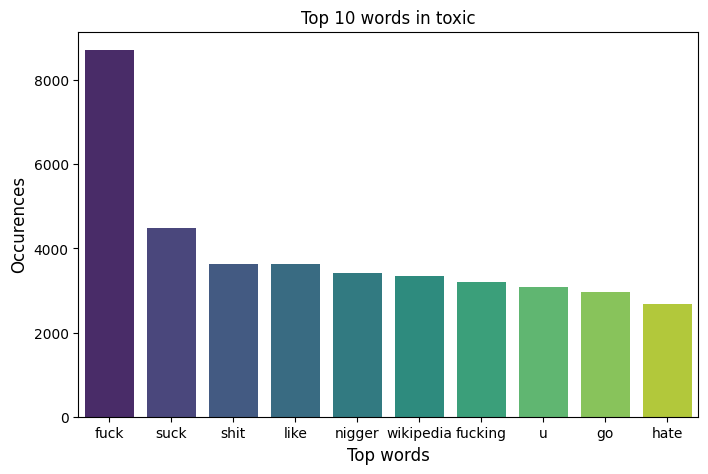

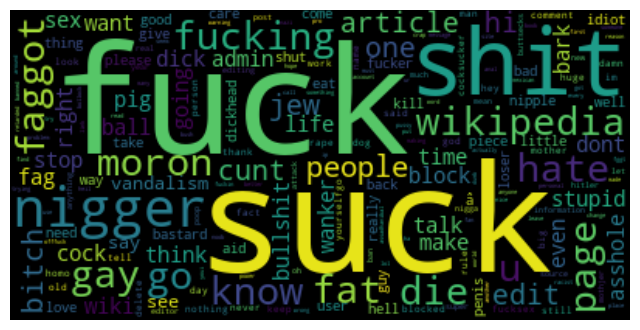

1590    filthy stinking crow back dirty crow better de...
1591       fucking pathetic moron cc jimbo wale rootmyass
1592           lol gay never know good feel fuck woman as
1593    walter mercado antonio quite frankly fucker co...
1594    shalom semite get fuck kill son bitch leave wi...
Name: cleaned_text, dtype: object


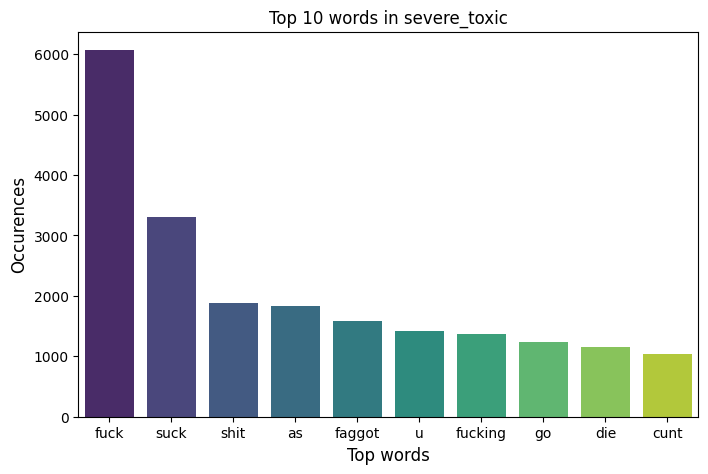

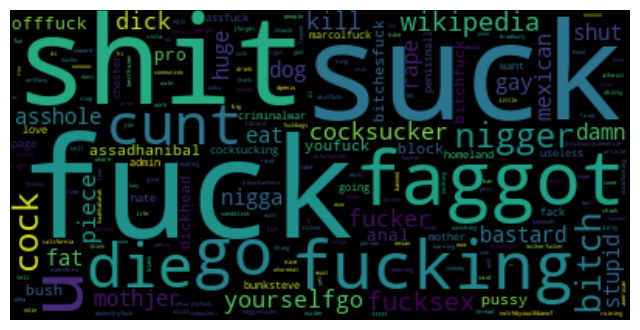

8444    fat piece shit obese piece shit thought naked ...
8445                                fucking faggot lolwat
8446    previous conversation fucking shit eating libe...
8447    absurd edits absurd edits great white shark to...
8448    going keep posting stuff u deleted fucking sit...
Name: cleaned_text, dtype: object


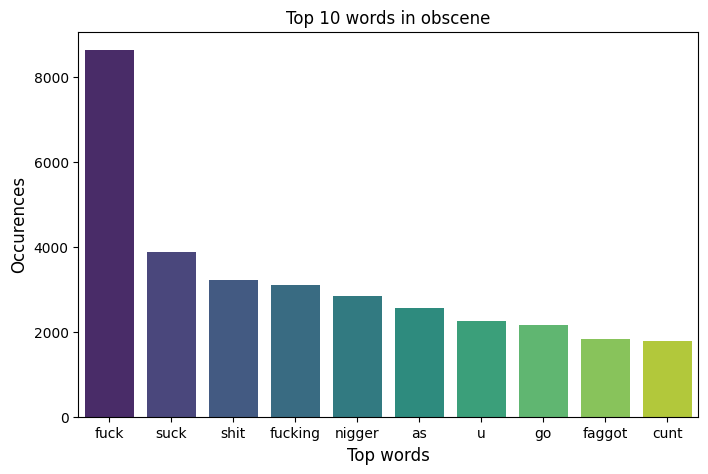

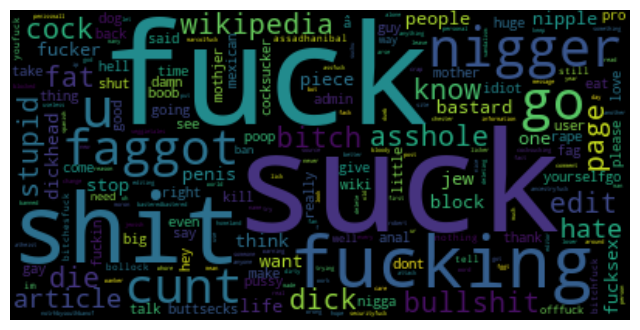

473    bitch fucking hore suck dick big as hole gay f...
474     stupid head dumb stupid die die die go suck butt
475    hey hey faggot dead yet watching mom getting r...
476                                      death musulmans
477    shalom semite get fuck kill son bitch leave wi...
Name: cleaned_text, dtype: object


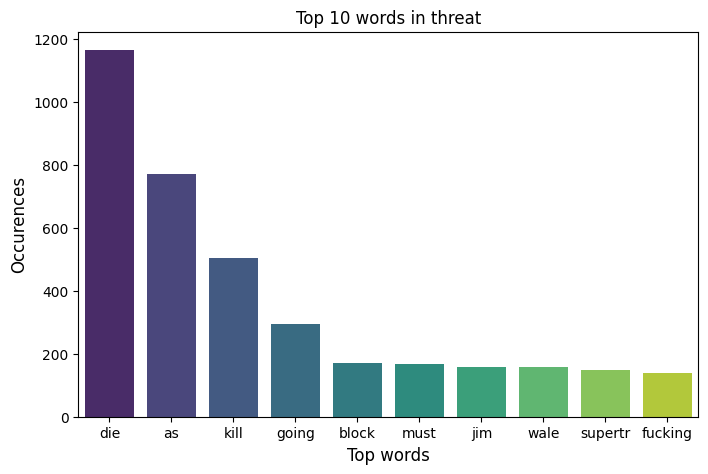

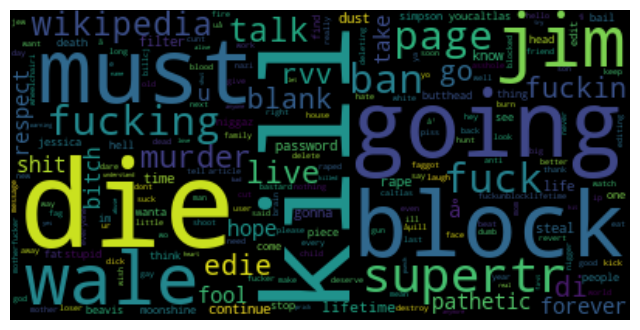

7872    previous conversation fucking shit eating libe...
7873                              mischievious pubic hair
7874    absurd edits absurd edits great white shark to...
7875    hey listen ever delete edits ever annoyed wwe ...
7876    going keep posting stuff u deleted fucking sit...
Name: cleaned_text, dtype: object


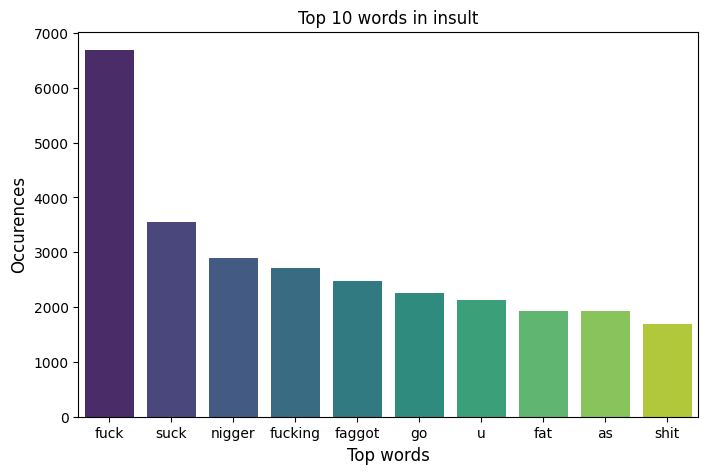

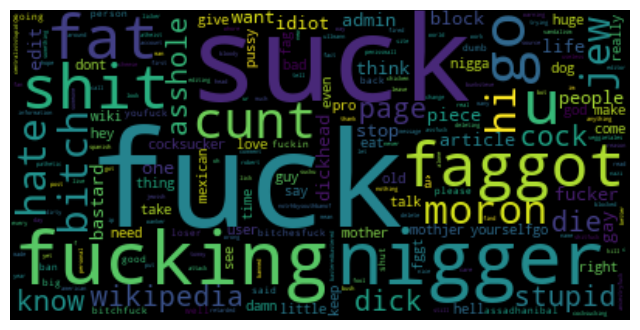

1400           lol gay never know good feel fuck woman as
1401    oh fuck pansy jew would whine bnai brith beat ...
1402    shalom semite get fuck kill son bitch leave wi...
1403                                        think gay fag
1404    previous conversation fucking shit eating libe...
Name: cleaned_text, dtype: object


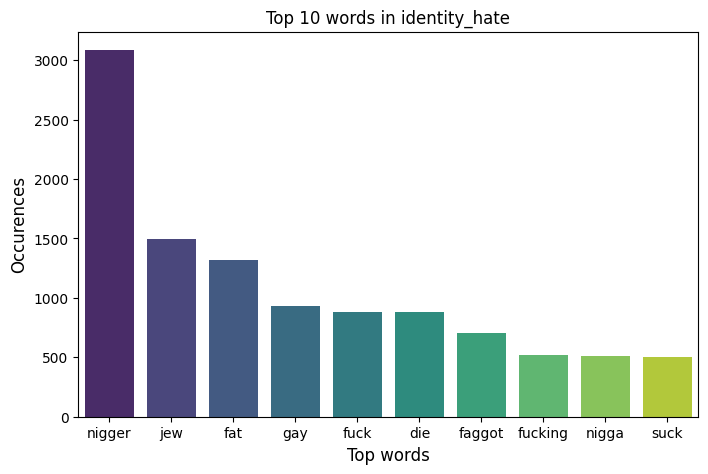

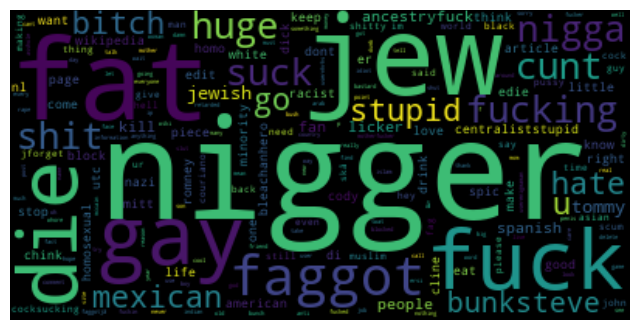

In [304]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

for label in LABELS:
    dataset_directory = "C:/Users/Feng/Coding projects/toxic-comments-datasets/"
    toxic = pd.read_csv(dataset_directory+'filtered_datasets/{}.csv'.format(label))

    cleaned = toxic['cleaned_text'].map(lambda text : text_cleaner(text, stop=stop_words))

    print(cleaned.tail())
    text2wc = " ".join(cleaned.values)

    wordcount = Counter(text2wc.split()).most_common()
    top10 = wordcount[:10]
    top10 = dict((x,y) for x, y in top10)
    top10df = pd.DataFrame(data = top10, index=[0])

    fig, ax = plt.subplots(figsize=(8,5))
    ax = sns.barplot(data = top10df, palette='viridis')
    plt.title("Top 10 words in {}".format(label))
    plt.ylabel('Occurences', fontsize=12)
    plt.xlabel('Top words', fontsize=12)

    wc= WordCloud(background_color="black", max_words=200, collocations=False, repeat=True)
    wc.generate(text2wc)

    fig, ax = plt.subplots(figsize=(8,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Sentiment Analysis

In [ ]:
# pip install -q transformers

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

In [ ]:
# data = ["I love you", "I hate you"]
sentiments = sentiment_pipeline(cleaned[0])
print(cleaned[0])
print(sentiments)

## LDA Topic Modelling

In [ ]:
df_processed_text.info()

In [ ]:
label_df = pd.read_csv('new_train.csv', usecols = ['cleaned_text', 
                                                   'toxic', 'severe_toxic', 
                                                   'obscene', 'threat', 
                                                   'insult', 'identity_hate']).dropna()
label_df = label_df.astype({'toxic':'int16',
                            'severe_toxic':'int16',
                            'obscene':'int16',
                            'threat':'int16',
                            'insult':'int16',
                            'identity_hate':'int16'})

LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_df = label_df[LABELS]

print(label_df.info())

In [ ]:

text2topic = new_train_df[new_train_df['severe_toxic']==1]['stop_removed_text']

text_clean = []
for text in text2topic:
    text_clean.append(text.split())

In [ ]:
print(type(text2topic))
print(text2topic.iloc[2])

In [ ]:
# Import the packages
import gensim
from gensim import corpora

# Define the dictionary
dictionary = corpora.Dictionary(text_clean)
# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in text_clean]
print(type(dictionary))
print(type(corpus))

# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=5)
print('finished ldamodel')
# Save the topics and top 5 words

topics = ldamodel.print_topics(num_words=10)

# Print the results
for topic in topics:
    print(topic)

# Old ML modelling

In [ ]:
x2 = scipy.sparse.load_npz('vectorized_comments.npz')
print(x2.shape)
print(type(x2))
# print(x2[159563])

In [ ]:
train, test = train_test_split(df,  random_state=42, test_size=0.25, shuffle=True)

In [ ]:
X_train = train.cleaned_text
X_test = test.cleaned_text
print(X_train.shape)
print(X_test.shape)

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
# Define a pipeline combining a text feature extractor with multi lable classifier
OVR_NB_pipeline = Pipeline([
                # ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [ ]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('countvectorizer', CountVectorizer(stop_words=stop_words)),
                # ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB()),
            ])

In [ ]:
save_models = ['toxic_model.sav', 'severe_toxic_model.sav', 'obscene_model.sav', 'threat_model.sav', 'insult_model.sav', 'identity_hate.sav'] 
label_models = ['toxic_model', 'severe_toxic_model', 'obscene_model', 'threat_model', 'insult_model', 'identity_hate'] 

for i, label in enumerate(labels):
    print('... Processing {}'.format(label))
    # train the model treating each label individually
    NB_pipeline.fit(X_train, train[label]) 
    
    # save the trained model
    file_path = 'saved_models/'+save_models[i]  
    pickle.dump(NB_pipeline, open(file_path, 'wb')) 


In [ ]:
for i, label in enumerate(labels):
    file_path = 'saved_models/'+save_models[i]
    loaded_model = pickle.load(open(file_path, 'rb'))
    # compute the testing accuracy
    y_pred = loaded_model.predict(X_test)
    y_test = test[label]
    # print('Test accuracy is {}'.format(accuracy_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))